<style>
.custom-font {
    font-family: 'Times New Roman', Times, serif;
    font-size: 48px;
    background-color: lightblue;
    color: black
}
</style>

<p class="custom-font">
DataLoader General



</p>


In [1]:
import torch
import torch_geometric
import h5py
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from torch_geometric.utils import to_undirected

In [2]:
class Graph():
    def __init__(self, node_features, node_coordinates, edges):
        """
        Initialize the class with node features, node coordinates, and edges.
        """
        self.nodes = node_features
        self.node_coordinates = node_coordinates
        self.edges = edges
        self.edge_index = torch.tensor(edges).T.contiguous()
        self.edge_index = to_undirected(self.edge_index)
        self.calculate_neighbors()
    
    def calculate_neighbors(self):
        self.neighbor = {}
        for e in self.edges:
            if e[0] not in self.neighbor:
                self.neighbor[e[0]] = set()
            if e[1] not in self.neighbor:
                self.neighbor[e[1]] = set()
            
            self.neighbor[e[0]].add(e[1])
            self.neighbor[e[1]].add(e[0])
    
    def get(self, node_representation='coordinate', edge_representation='list'):
        """
        Retrieves the nodes and edges of the graph.
        """
        nodes = None
        edges = None

        if node_representation == 'coordinate':
            nodes = self.nodes
        else:
            raise NotImplementedError(f"Not defined nodes representation '{node_representation}'")

        if edge_representation == 'list':
            edges = self.edges
        else:
            raise NotImplementedError(f"Not defined edge representation '{edge_representation}'")
        
        return nodes, edges
    
    def get_plot_data(self):
        nx_graph = nx.from_edgelist(self.edges)
        pos = {k: x for k, x in enumerate(self.node_coordinates)}

        return nx_graph, pos
    
    def plot(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots()
        
        nx_graph = nx.from_edgelist(self.edges)

        pos = {k: x for k, x in enumerate(self.node_coordinates)}
        nx.draw_networkx(nx_graph, with_labels=False, pos=pos, ax=ax)
    
    def get_neighbors(self, node):
        return self.neighbor[node]
    
class Trajectory:
    def __init__(self, graph, edge_indices, edge_orientation, representation='index'):
        self.edge_indices = edge_indices
        self.edges = graph.edges[edge_indices]
        self.representation = representation
        self.edge_orientation = edge_orientation

        for i in range(len(self.edges)):
            if edge_orientation[i] == -1:
                self.edges[i] = self.edges[i][::-1]
    
    def __getitem__(self, idx):
        if self.representation == 'index':
            return self.edge_indices[idx], self.edge_orientation[idx]
        elif self.representation == 'srctar':
            return self.edges[idx]
    
    def __len__(self): 
        return len(self.edge_indices)
    
    def as_tensor(self):
        if self.representation == 'index':
            return self.edge_indices
        elif self.representation == 'srctar':
            return self.edges

    def plot(self, graph, ax=None):
        if ax is None:
            fig, ax = plt.subplots()
        
        nx_graph, pos = graph.get_plot_data()

        nx.draw_networkx(nx_graph, with_labels=False, pos=pos, ax=ax, node_size=10, alpha=0.4)
        nx.draw_networkx_edges(nx_graph, pos=pos, edgelist=self.edges, ax=ax, edge_color='red', width=2, node_size=0)


<style>
.custom-font {
    font-family: 'Times New Roman', Times, serif;
    font-size: 48px;
    background-color: lightblue;
    color: black
}
</style>

<p class="custom-font">
DataLoader for T-Drive Dataset



</p>


In [8]:
class BaseTrajectoryDataset(torch.utils.data.Dataset):
    def __init__(self):
        super().__init__()
        self.trajectories = []
        self.graph = None

    def __getitem__(self, idx):
        return self.trajectories[idx].as_tensor()
    
    def __len__(self): 
        return len(self.trajectories)
    
    def getGraph(self):
        return self.graph

class TDriveTrajectoryDataset(BaseTrajectoryDataset):
    def __init__(self, path, n_samples=-1, node_features=[], min_trajectory_length=0, max_trajectory_length=-1, edge_format='index'):
        super().__init__()
        self.path = path
        self.n_samples = n_samples
        self.node_features = node_features
        self.min_trajectory_length = min_trajectory_length
        self.max_trajectory_length = max_trajectory_length
        self.edge_format = edge_format
        self.load_dataset()
    
    def load_dataset(self):
        with h5py.File(self.path, "r") as f:
            # Load graph
            graph = f['graph']
            edge_list = graph['edges'][()]
            node_coordinates = graph['node_coordinates'][()]
            if len(self.node_features) == 0:
                node_features = [x for x in range(node_coordinates.shape[0])]
            self.graph = Graph(node_features, node_coordinates, edge_list)
            
            # Load trajectories
            trajects = f['trajectories']
            self.trajectories = []
            for file_ix in trajects.keys():
               
                trajectory = trajects[file_ix]['edge_idxs'][:]
                    
                #check if current trajectory is within the range of min and max trajectory length
                if trajectory.shape[0] >= self.min_trajectory_length and (self.max_trajectory_length < 0 or trajectory.shape[0] <= self.max_trajectory_length):
                    edge_orientations = trajects[file_ix]['edge_orientations'][:]
                    self.trajectories.append(Trajectory(self.graph, trajectory, edge_orientations, representation=self.edge_format))
                
                # benchsize; set the number of samples load for one iteration
                if self.n_samples > 0 and len(self.trajectories) >= self.n_samples:
                    return

In [9]:
data = TDriveTrajectoryDataset('../T-drive/tdrive.h5', n_samples=10, min_trajectory_length=5, max_trajectory_length=8, edge_format='srctar')

In [10]:
# check the data format
print(type(data))

print(type(data[0]))
print(data[0].shape)
print(data[0])

print(data[0][2])

<class '__main__.TDriveTrajectoryDataset'>
<class 'numpy.ndarray'>
(5, 2)
[[ 567 1489]
 [1489 1952]
 [1952 4368]
 [4368 7686]
 [7686 3607]]
[1952 4368]


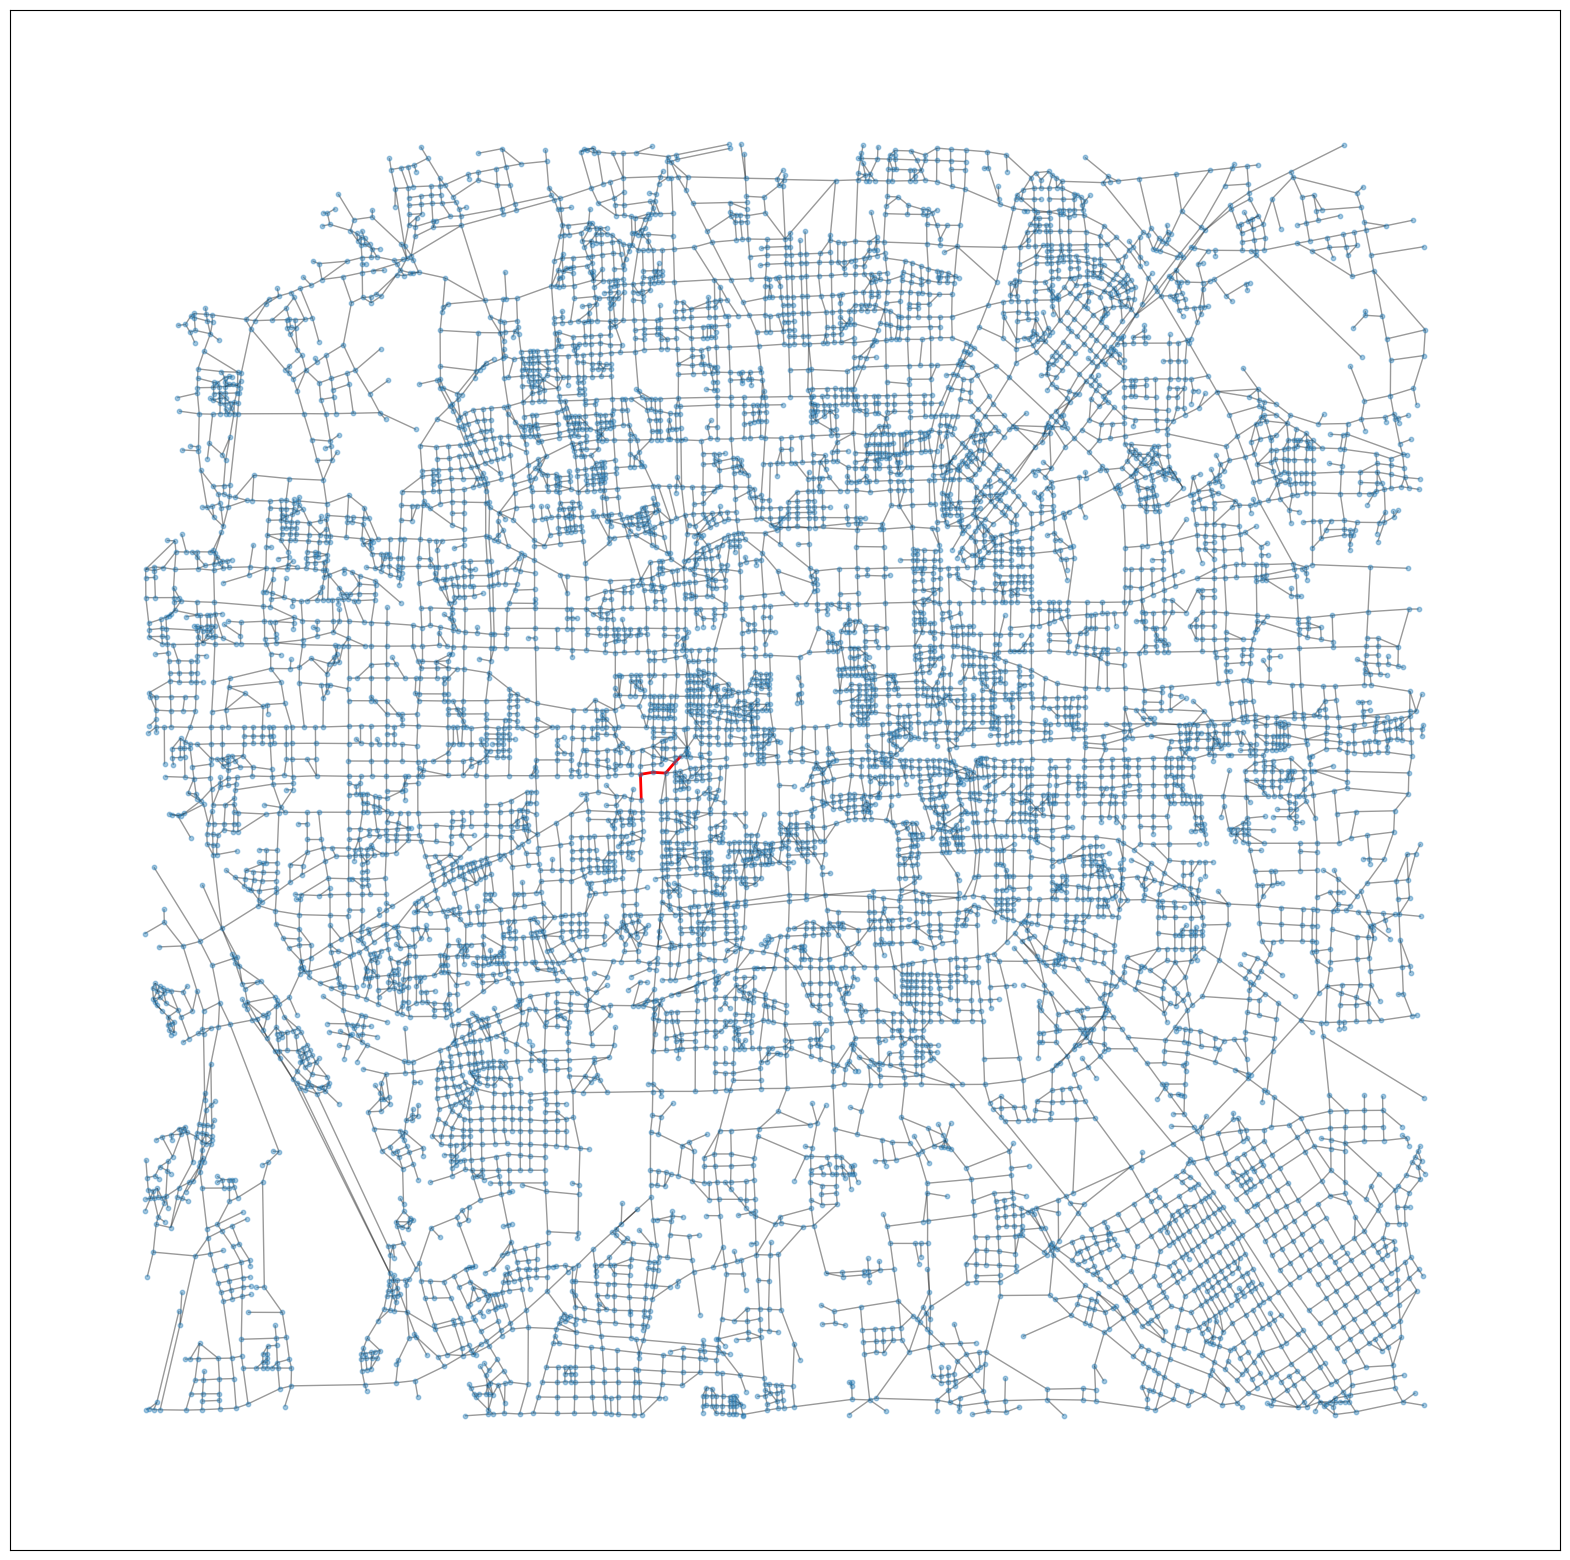

In [11]:
# visulize the trajectories from the list "trajectories" created by the dataloader
fig, ax = plt.subplots(figsize=(20, 20))
data.trajectories[0].plot(data.graph, ax)